#Analyse des sentiments

L'analyse de sentiment à l'aide de réseaux de neurones à mémoire à long terme (LSTM) implique l'utilisation d'un type de réseau neuronal récurrent (RNN) particulièrement efficace pour capturer les dépendances dans les données séquentielles. L'idée est de fournir au réseau LSTM des séquences de mots (ou de jetons) à partir d'un texte, et le réseau apprend à comprendre le sentiment du texte en se basant sur le contexte fourni par les mots environnants.

Voici une explication étape par étape de la façon de réaliser une analyse de sentiment en utilisant un LSTM :

1. **Préparation des données** :

   - **Données d'Entrée** :
     Désignons nos données d'entrée par $X$, où $X$ est une séquence de mots ou de jetons. Chaque mot ou jeton est représenté sous forme de vecteur (généralement par des techniques comme les plongements de mots, par exemple Word2Vec, GloVe, etc.).
     
     $X = [x_1, x_2, ..., x_T]$, où $T$ est la longueur de la séquence.

   - **Étiquette** :
     Pour l'analyse de sentiment, vous avez besoin de données étiquetées où chaque entrée $X$ est associée à une étiquette de sentiment, généralement binaire (positif ou négatif) ou multi-classe (positif, neutre, négatif).

     $Y = [y_1, y_2, ..., y_T]$, où $y_t$ représente l'étiquette de sentiment pour le $t$-ième mot dans la séquence.

2. **Architecture LSTM** :

   L'architecture LSTM peut être représentée comme suit :

   - $i_t = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})$ (Porte d'Entrée)
   - $f_t = \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})$ (Porte d'Oubli)
   - $g_t = \tanh(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})$ (Porte de Cellule)
   - $o_t = \sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})$ (Porte de Sortie)
   - $c_t = f_t \cdot c_{t-1} + i_t \cdot g_t$ (État de Cellule)
   - $h_t = o_t \cdot \tanh(c_t)$ (État Caché)

   Ici, $x_t$ est le vecteur d'entrée à l'instant $t$, $h_t$ est l'état caché à l'instant $t$, $c_t$ est l'état de cellule à l'instant $t$, et $\sigma$ représente la fonction d'activation sigmoïde.

   $W$ et $b$ sont les matrices de poids et les vecteurs de biais, respectivement.

3. **Passage Avant** :

   Pour chaque instant $t$, vous effectuez les calculs décrits dans les équations LSTM ci-dessus. Vous parcourez l'ensemble de la séquence $X$.

4. **Fonction de Perte** :

   Vous utilisez une fonction de perte pour quantifier l'erreur entre le sentiment prédit et les étiquettes de sentiment réelles. Les fonctions de perte couramment utilisées pour l'analyse de sentiment comprennent la perte de cross-entropy.

   $L(y, \hat{y}) = - \sum_{i} y_i \log(\hat{y}_i)$, où $y$ est la distribution des étiquettes réelles et $\hat{y}$ est la distribution des étiquettes prédites.

5. **Rétropropagation et Optimisation** :

   Après avoir calculé la perte, vous effectuez la rétropropagation pour mettre à jour les poids et les biais afin de minimiser la perte. Des techniques comme la descente de gradient stochastique (SGD) ou des optimiseurs plus avancés comme Adam peuvent être utilisées à cette fin.

6. **Entraînement** :

   Vous parcourez vos données d'entraînement sur plusieurs époques, en ajustant les paramètres du modèle à chaque fois.

7. **Validation et Test** :

   Après l'entraînement, vous évaluez le modèle sur un ensemble de validation pour surveiller les performances et apporter des ajustements si nécessaire. Enfin, vous testez le modèle sur un ensemble de test distinct pour obtenir une estimation impartiale de ses performances.



In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import seaborn as sns
from collections import Counter

In [ ]:
import torch
import torch.nn as nn

In [ ]:
#!gdown --id 1fkW51Bd1WQy52U9Yg9dn2Gk67V4_n5GA

Chargez l'ensemble de données et vérifiez s'il existe des valeurs NaN ou Null.
Vérifiez également la forme de l'ensemble de données.

In [ ]:
movie_reviews = pd.read_csv(r"IMDB-Dataset.csv", encoding = 'latin1')

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

Affichez les cinq premières lignes des données à l'aide de la méthode head().

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Tracez les étiquettes à l'aide d'un diagramme à barres pour vérifier les types d'étiquettes et leur nombre.

<Axes: xlabel='sentiment', ylabel='count'>

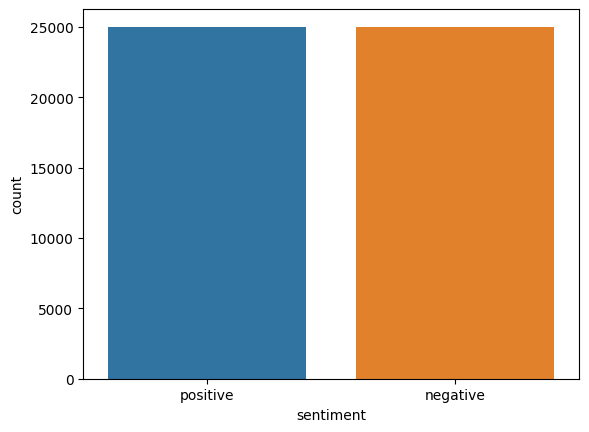

In [ ]:
sns.countplot(x = 'sentiment' , data = movie_reviews)

## Étape de prétraitement des données.
Définir des fonctions pour éliminer les balises HTML, les ponctuations, les caractères supplémentaires et les espaces multiples du texte donné dans l'ensemble de données.

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

Prétraitement des données à l'aide des fonctions de nettoyage des données définies ci-dessus.

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))


Vérifiez si les données sont nettoyées.

In [ ]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

Préparer les étiquettes et les convertir des étiquettes de chaîne en formulaires « 0 » et « 1 » à des fins de formation.

In [ ]:
y = list(movie_reviews['sentiment'])

y = np.array(list(map(lambda x : 1 if x == 'positive' else 0, y)))

Diviser l'ensemble de données en données de train et données de test.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Préparation du texte pour alimenter l'algorithme.
Définir le vocabulaire et convertir des textes/phrases en séquences.

In [ ]:
vocab_size=1000
all_tokens=[]
for example in X_train:
  all_tokens.extend(example.split(' '))

vocab = [word[0] for word in Counter(all_tokens).most_common(vocab_size)]
word2id = { vocab[i]: i for i in range(len(vocab)) }

In [ ]:
from tqdm.notebook import tqdm
x_train,x_test= [],[]
for sent in tqdm(X_train):
            tmp=[word2id[word]  for word in sent.split(' ') if word in vocab]
            new_seq=np.zeros(100)
            if len(tmp)>100:
              x_train.append(tmp[:100] )
            else:
              new_seq[:len(tmp)]=tmp
              x_train.append(new_seq )

for sent in tqdm(X_test):
            tmp=[word2id[word]  for word in sent.split(' ') if word in vocab]
            new_seq=np.zeros(100)
            if len(tmp)>100:
              x_test.append(tmp[:100] )
            else:
              new_seq[:len(tmp)]=tmp
              x_test.append(new_seq )

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Remplissage de toutes les séquences pour avoir les mêmes dimensions partout et maintenir l'homogénéité entre elles à des fins de formation.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

x_train,x_test= torch.Tensor(x_train) ,torch.Tensor(x_test)
y_train,y_test  =torch.Tensor(Y_train), torch.Tensor(Y_test)


<ipython-input-15-7ce12f549745>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  x_train,x_test= torch.Tensor(x_train) ,torch.Tensor(x_test)


In [ ]:
batch_size=1024
my_dataset = TensorDataset(x_train,y_train)
train_loader = DataLoader(my_dataset,batch_size=batch_size)

my_dataset = TensorDataset(x_test,y_test)
test_loader = DataLoader(my_dataset,batch_size=batch_size)

## Préparation des  Embeddings GloVe pour les utiliser dans la formation du modèle.

GloVe, qui signifie Global Vectors for Word Representation, est un algorithme d'apprentissage non supervisé permettant d'obtenir des représentations vectorielles pour les mots. Ces vecteurs (incrustations) sont conçus pour capturer les relations sémantiques entre les mots en se basant sur les statistiques de co-occurrence dans de grands corpus de texte.

En d'autres termes, GloVe cherche à représenter les mots dans un espace vectoriel continu de telle sorte que les mots qui apparaissent fréquemment ensemble dans le même contexte soient proches les uns des autres dans cet espace. Cela permet des opérations mathématiques significatives sur ces vecteurs, telles que l'addition et la soustraction de vecteurs, qui peuvent capturer des analogies et des relations entre les mots.


In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
#!unzip glove.6B.zip

In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in enumerate(word2id.keys()):
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Définir du model en Pytorch
Définissez la couche d'intégration à l'aide des poids GloVe et d'une couche LSTM avec 128 neurones et à la dernière couche dense avec le neurone final avec activation « sigmoïde ».
Enfin, compilez le modèle ayant « binaire_crossentropy » comme fonction de perte, « adam » comme optimiseur avec « précision » comme métrique.


Explications :

1. **Imports** :
   ```python
   import torch
   import torch.nn as nn
   ```
   Ces lignes importent les bibliothèques nécessaires de PyTorch. `torch` est la bibliothèque principale de PyTorch, et `nn` est le module de réseaux de neurones.

2. **Définition de la Classe** :
   ```python
   class SentimentLSTM(nn.Module):
   ```
   Cela définit une nouvelle classe nommée `SentimentLSTM` qui hérite de `nn.Module`. Cela signifie que notre modèle est un module PyTorch et héritera de toutes les fonctionnalités d'un module PyTorch standard.

3. **Fonction d'Initialisation** :
   ```python
   def __init__(self, vocabulaire_taille, dimension_embedding, taille_cachee, num_couches, taille_sortie):
   ```
   C'est la fonction d'initialisation où nous définissons l'architecture de notre modèle. Elle prend cinq arguments :
   - `vocabulaire_taille` : La taille du vocabulaire, c'est-à-dire le nombre total de mots uniques dans le corpus.
   - `dimension_embedding` : La dimension des vecteurs d'embedding utilisés pour représenter les mots.
   - `taille_cachee` : Le nombre de caractéristiques dans l'état caché de la LSTM.
   - `num_couches` : Le nombre de couches récurrentes dans la LSTM.
   - `taille_sortie` : Le nombre de classes ou d'étiquettes en sortie (par exemple, 2 pour l'analyse de sentiment binaire).

4. **Initialisation Super** :
   ```python
   super(SentimentLSTM, self).__init__()
   ```
   Cette ligne appelle la méthode d'initialisation de la classe parente `nn.Module`. C'est nécessaire pour s'assurer que le modèle est correctement initialisé.

5. **Couche d'Embedding** :
   ```python
   self.embedding = nn.Embedding(vocabulaire_taille, dimension_embedding)
   ```
   Cela crée une couche d'embedding avec une taille de vocabulaire spécifiée (`vocabulaire_taille`) et une dimension d'embedding spécifiée (`dimension_embedding`). Cette couche va convertir les indices de mots en vecteurs denses.

6. **Couche LSTM** :
   ```python
   self.lstm = nn.LSTM(dimension_embedding, taille_cachee, num_couches, batch_first=True)
   ```
   Cela crée une couche LSTM avec `dimension_embedding` de caractéristiques en entrée, `taille_cachee` d'unités cachées, `num_couches` de couches récurrentes, et `batch_first=True` pour indiquer que les données d'entrée auront la taille de lot en première dimension.

7. **Couche Entièrement Connectée** :
   ```python
   self.fc = nn.Linear(taille_cachee, taille_sortie)
   ```
   Cela crée une couche entièrement connectée qui va mapper la sortie de la LSTM vers la taille de sortie désirée (le nombre de classes).

8. **Fonction Forward** :
   ```python
   def forward(self, x):
   ```
   Cette méthode définit la passe avant du modèle. Elle prend une entrée `x` et la fait passer à travers les couches définies dans la méthode `__init__`.

9. **Passage d'Embedding** :
   ```python
   out = self.embedding(x)
   ```
   Cette ligne effectue la passe avant à travers la couche d'embedding. Elle convertit les indices de mots en vecteurs d'embedding.

10. **Passage LSTM** :
    ```python
    out, (hn, cn) = self.lstm(out)
    ```
    Cette ligne effectue la passe avant à travers la couche LSTM. `out` contient les caractéristiques de sortie de tous les pas de temps, et `(hn, cn)` contient l'état caché et l'état de cellule du dernier pas de temps.

11. **Extraction de la Sortie** :
    ```python
    out = out[:, -1, :]
    ```
    Cette ligne extrait la sortie du dernier pas de temps. Dans ce cas, nous supposons que le sentiment de la séquence entière peut être capturé par la sortie de la LSTM au dernier pas de temps. Selon la tâche spécifique, vous pourriez utiliser une stratégie différente pour agréger la sortie.

12. **Passage Entièrement Connecté** :
    ```python
    out = self.fc(out)
    ```
    Cette ligne fait passer la sortie à travers la couche entièrement connectée.

13. **Renvoi de la Sortie** :
    ```python
    return out
    ```
    La sortie finale du modèle est renvoyée.

Ce code fournit une structure de base pour un modèle d'analyse de sentiment basé sur une LSTM avec une couche d'embedding apprise. Selon votre ensemble de données et votre tâche spécifique, vous pourriez avoir besoin d'apporter d'autres ajustements ou d'ajouter des composants supplémentaires (par exemple, dropout, normalisation par lots) pour améliorer les performances.

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocabulaire_taille,weight_matrix, dimension_embedding, taille_cachee, num_couches, taille_sortie):
        super(SentimentLSTM, self).__init__()

        # Couche d'embedding
        self.embedding = nn.Embedding(vocabulaire_taille, dimension_embedding).requires_grad_(False)
        self.embedding.weights = torch.nn.Parameter(torch.from_numpy(weight_matrix))
        # Couche LSTM
        self.lstm = nn.LSTM(dimension_embedding, taille_cachee, num_couches, batch_first=True)

        # Couche entièrement connectée
        self.fc = nn.Linear(taille_cachee, taille_sortie)

    def forward(self, x):
        # Passe avant à travers la couche d'embedding
        out = self.embedding(x)

        # Passe avant à travers la couche LSTM
        out, (hn, cn) = self.lstm(out)

        # Prendre la sortie de la dernière étape de temps
        out = out[:, -1, :]

        # Passe à travers la couche entièrement connectée
        out = self.fc(out)

        return out

In [ ]:
model =SentimentLSTM(vocab_size,embedding_matrix,100,128,1,1).cuda()




Explications:

1. **Classe de Dataset Personnalisée** :
   - Nous définissons une classe de dataset personnalisée (`DatasetSentiment`) qui sera utilisée pour charger les données d'entraînement et de test.

2. **Ensembles de Données d'Entraînement et de Test** :
   - Nous générons des données d'entraînement et de test distinctes.

3. **Dataset et DataLoader** :
   - Nous créons des ensembles de données et des dataloaders correspondants pour l'entraînement et le test.

4. **Modèle, Fonction de Perte et Optimiseur** :
   - Nous définissons le modèle, la fonction de perte (Entropie Croisée Binaire) et l'optimiseur comme précédemment.

5. **Boucle d'Entraînement** :
   - Nous bouclons sur le nombre spécifié d'époques.
   - Pour chaque époque, nous effectuons l'entraînement sur l'ensemble d'entraînement.
   - Après l'entraînement, nous évaluons le modèle sur l'ensemble de test et calculons la précision.

6. **Sauvegarde du Meilleur Modèle** :
   - Si la précision sur le test s'améliore, nous sauvegardons les poids du modèle en tant que `meilleur_modele.pth`.

Ce code intègre désormais des ensembles de données d'entraînement et de test séparés, utilise des dataloaders et sauvegarde les poids du modèle lorsque la performance sur le test s'améliore. Si la précision sur le test dépasse la précédente meilleure, il sauvegardera le modèle.

In [ ]:
num_epochs=100
criterion = nn.BCELoss()
optimiseur = torch.optim.Adam(model.parameters(), lr=0.001)

meilleure_precision = 0.0

# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    perte_totale = 0.0

    for entrees, etiquettes in tqdm(train_loader):
        optimiseur.zero_grad()
        entrees, etiquettes=entrees.long().cuda(), etiquettes.float().cuda()
        sorties = model(entrees)
        perte = criterion(torch.sigmoid(sorties.squeeze()), etiquettes.float())
        perte.backward()
        optimiseur.step()
        perte_totale += perte.item()

    perte_moyenne = perte_totale / len(train_loader)
    print(f'Époque [{epoch+1}/{num_epochs}], Perte : {perte_moyenne:.4f}')

    # Évaluation sur l'ensemble de test
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for entrees, etiquettes in tqdm(test_loader):
            entrees, etiquettes=entrees.long().cuda(), etiquettes.float().cuda()
            sorties = model(entrees)
            predites = torch.round(torch.sigmoid(sorties))
            total += etiquettes.size(0)
            correct += (predites.view(-1) == etiquettes.float()).sum().item()

    precision = correct / total
    print(f'Précision sur le test : {precision:.4f}')

    # Sauvegarder le meilleur modèle
    if precision > meilleure_precision:
        meilleure_precision = precision
        torch.save(model.state_dict(), 'meilleur_modele.pth')

print('Entraînement terminé !')

  0%|          | 0/40 [00:00<?, ?it/s]

Époque [1/100], Perte : 0.6901


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.5606


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [2/100], Perte : 0.6581


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.6537


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [3/100], Perte : 0.6216


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.6539


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [4/100], Perte : 0.6077


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7024


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [5/100], Perte : 0.5615


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7407


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [6/100], Perte : 0.5051


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7557


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [7/100], Perte : 0.4664


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7824


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [8/100], Perte : 0.4615


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7913


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [9/100], Perte : 0.4080


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7920


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [10/100], Perte : 0.3866


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7902


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [11/100], Perte : 0.3688


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7840


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [12/100], Perte : 0.3603


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8107


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [13/100], Perte : 0.3507


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8209


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [14/100], Perte : 0.3557


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8225


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [15/100], Perte : 0.3336


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8227


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [16/100], Perte : 0.3237


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8174


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [17/100], Perte : 0.3380


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8129


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [18/100], Perte : 0.3237


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8053


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [19/100], Perte : 0.3086


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8168


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [20/100], Perte : 0.3029


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8250


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [21/100], Perte : 0.2939


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8180


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [22/100], Perte : 0.2827


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7934


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [23/100], Perte : 0.2751


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8204


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [24/100], Perte : 0.3034


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8168


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [25/100], Perte : 0.2733


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8126


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [26/100], Perte : 0.2678


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8223


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [27/100], Perte : 0.2737


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7870


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [28/100], Perte : 0.3017


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8188


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [29/100], Perte : 0.2648


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8227


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [30/100], Perte : 0.2561


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8204


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [31/100], Perte : 0.2609


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8053


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [32/100], Perte : 0.2426


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8013


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [33/100], Perte : 0.2448


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8016


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [34/100], Perte : 0.2341


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7908


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [35/100], Perte : 0.2548


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8115


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [36/100], Perte : 0.2090


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8013


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [37/100], Perte : 0.1843


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8176


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [38/100], Perte : 0.1653


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8201


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [39/100], Perte : 0.1559


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8194


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [40/100], Perte : 0.1495


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8119


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [41/100], Perte : 0.1478


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8083


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [42/100], Perte : 0.1514


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8152


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [43/100], Perte : 0.1730


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7223


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [44/100], Perte : 0.2245


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8201


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [45/100], Perte : 0.1336


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8158


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [46/100], Perte : 0.1234


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8160


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [47/100], Perte : 0.1162


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7974


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [48/100], Perte : 0.1214


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7958


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [49/100], Perte : 0.1811


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8093


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [50/100], Perte : 0.1635


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7965


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [51/100], Perte : 0.1247


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8127


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [52/100], Perte : 0.1145


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8100


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [53/100], Perte : 0.1184


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7845


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [54/100], Perte : 0.1861


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7677


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [55/100], Perte : 0.1901


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8042


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [56/100], Perte : 0.1351


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8081


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [57/100], Perte : 0.1346


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8072


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [58/100], Perte : 0.1418


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8121


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [59/100], Perte : 0.1380


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8070


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [60/100], Perte : 0.1269


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8027


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [61/100], Perte : 0.1260


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8016


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [62/100], Perte : 0.1320


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7906


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [63/100], Perte : 0.1581


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7662


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [64/100], Perte : 0.1763


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7241


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [65/100], Perte : 0.1905


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8134


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [66/100], Perte : 0.0938


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8087


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [67/100], Perte : 0.0635


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8102


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [68/100], Perte : 0.0555


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8092


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [69/100], Perte : 0.0497


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8078


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [70/100], Perte : 0.0456


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8060


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [71/100], Perte : 0.0423


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8042


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [72/100], Perte : 0.0397


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8028


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [73/100], Perte : 0.0428


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8073


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [74/100], Perte : 0.0447


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8014


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [75/100], Perte : 0.0478


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8036


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [76/100], Perte : 0.0493


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8040


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [77/100], Perte : 0.0554


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8047


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [78/100], Perte : 0.0701


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7928


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [79/100], Perte : 0.0641


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7809


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [80/100], Perte : 0.0665


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8027


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [81/100], Perte : 0.0703


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7724


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [82/100], Perte : 0.1023


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7778


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [83/100], Perte : 0.1265


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7709


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [84/100], Perte : 0.1022


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8037


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [85/100], Perte : 0.0436


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8059


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [86/100], Perte : 0.0278


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8065


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [87/100], Perte : 0.0238


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8054


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [88/100], Perte : 0.0215


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8052


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [89/100], Perte : 0.0196


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8028


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [90/100], Perte : 0.0181


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8007


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [91/100], Perte : 0.0170


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7988


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [92/100], Perte : 0.0159


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7982


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [93/100], Perte : 0.0150


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7982


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [94/100], Perte : 0.0142


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7992


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [95/100], Perte : 0.0134


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7981


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [96/100], Perte : 0.0131


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7983


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [97/100], Perte : 0.0137


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.7983


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [98/100], Perte : 0.0129


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8000


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [99/100], Perte : 0.0126


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8004


  0%|          | 0/40 [00:00<?, ?it/s]

Époque [100/100], Perte : 0.0114


  0%|          | 0/10 [00:00<?, ?it/s]

Précision sur le test : 0.8007
Entraînement terminé !


## Étape de prédiction.
Prédisez une critique de film pour vérifier si notre modèle prédit avec exactitude et précision en fonction de ses performances.

In [ ]:
instance = "A good insight on the hopeless state of Russian modern society. Integrity and good can be found only in interpersonal relations, not in social institutions which are totally corrupted. The movie is a little bit slow, but still catching."
sent=preprocess_text(instance)

In [ ]:
tmp=[word2id[word]  for word in sent.split(' ') if word in vocab]
new_seq=np.zeros((1,100))
if len(tmp)>100:
              new_seq[0] =tmp[:100]
else:
              new_seq[0,:len(tmp)]=tmp


In [ ]:
flat_list =torch.from_numpy(new_seq).cuda().long()

In [ ]:

with torch.no_grad():
  z=model(flat_list).detach().cpu().numpy().reshape(-1)
  z = 1/(1 + np.exp(-z))
if z > 0.5 :

    print("Cest une critique positive. Je suis heureux d'avoir un avis positif de votre part.")

else :
    print("Oops!! cest un avis négatif.")

Cest une critique positive. Je suis heureux d'avoir un avis positif de votre part.
